In [1]:
import numpy as np
import tensorflow_probability as tfp
from scipy.integrate import odeint

from rnn_library import rnn_functions as rnn # importing local package as rnn
                                             # for details see rnn_functions.py file in rnn_libary folder 

import matplotlib.pyplot as plt

In [7]:
def NL_DifEq(x,t):
    """
    NL_DifEq specifies the set of ODE's that need to be solved.
    Applied within odeint. For more details look into scipy.integrate.odeint

    Requierements:
    
    x         -   initial value satisfied by Initial_Condition.
    t         -   timeline satsfied by 
    
    Output:
    
    dxdt     -   the change in the dynamic network variable x
    """
    
    dxdt = - x + J_Matrix @ np.tanh(x) 
    
    return dxdt

In [8]:
'''
In this cell we ask the user to specify 
the network parameters:
g, K, N_values, s_values
'''

print('Specify the value of the gain parameter, g.')
g = rnn.ask_user_float() # stores the value of the gain parameter in the network; datatype float

print('Specify the number of distinct self-couplings.')
K = rnn.ask_user_integer() # stores the total number of distinct clusters; datatype positive int 

N_values = np.zeros(K) # create memory space; stores number of clusters for each population
s_values = np.zeros(K) # create memory space; stores values of self-coupling each cluster population

for idx in range(K):
    
    print(f'Population {idx}:\n s{idx} =',)
    s_values[idx] = rnn.ask_user_float() # stores the self_coupling value for cluster idx
    
    print(f'Population {idx}:\n N{idx} =',)
    N_values[idx] = rnn.ask_user_integer() # stores number of cluster with self_coupling s_value[idx]
    
N = int(N_values.sum()) # stores total number of clusters in the network

Specify the value of the gain parameter, g.
2.0
	Entry accepted
Specify the number of distinct self-couplings.
2
	Entry accepted
Population 0:
 s0 =
1.0
	Entry accepted
Population 0:
 N0 =
800
	Entry accepted
Population 1:
 s1 =
3.0
	Entry accepted
Population 1:
 N1 =
200
	Entry accepted


In [9]:
# Specifying the timeline for solving the coupled ODEs

t_end = 1000.0                        # end of time  
dt = 0.1                              # timestep
timeline = np.arange(0, t_end, dt)    # stores time values t0 = 0, t1= 0.1, ....

# Specifying the timeline for the autocorrelation funcion (ACF)

steps_ignore = 500                             # minimum value 1 (see how the ACF is computed)
Tau_Steps = int((t_end*(1/dt)-steps_ignore))   # total number of steps for the ACF timeline
tau_timeline = np.arange(0,Tau_Steps,1.0)*dt   # stores time values t0 = 0, t1= 0.1, ....

# Specifying the network connectivity matrix J

# J is extracted from a normal distribution with mean 0 and variance g/sqrt(N)

mean  = 0.0                                          # mean of the distribution
variance  = g/np.sqrt(N)                             # variance of teh distribution
J_Matrix = variance * np.random.randn(N**2) + mean   # returns an array of size N*N
J_Matrix = J_Matrix.reshape(N,N)                     # reshaping the array into a NxN matrix

# Specifying the diagonal elements of the J matrix

diagonal = np.ones(N)
temp_pos_var = 0 # not an elegant solution, but it works
for idx in range(K):
    range_start = int(temp_pos_var)
    range_end = int(temp_pos_var+N_values[idx])
    
    diagonal[range_start:range_end] = diagonal[range_start:range_end]* s_values[idx]
    
    temp_pos_var = N_values[idx]
    
for cluster in range(N):
    J_Matrix[cluster][cluster] = diagonal[cluster]

# Specifying the initial conditions x(t = 0)
Initial_Condition = np.random.uniform(-2,2, N) # N size array from uniform distr. ranging from -2 to 2

In [10]:
# Solving the system of coupled ODE with the specified parameters

x = odeint(NL_DifEq, Initial_Condition, timeline).T

# Solving for the ACF < phi[x(t)] phi[x(t+tau)] > ; phi[x] = tanh[x]

C_phi   = tfp.stats.auto_correlation(np.tanh(x[:,steps_ignore:]), axis =-1, max_lags = Tau_Steps, center = False, normalize = True)

# Averaging the ACF per cluster population
C_phi_avg = []

temp_pos_var = 0 # not an elegant solution, but it works
for idx in range(K):
    range_start = int(temp_pos_var)
    range_end = int(temp_pos_var+N_values[idx])
    
    C_phi_avg.append(np.mean( C_phi[range_start:range_end] , axis = 0))
    
    temp_pos_var = N_values[idx]

2022-02-23 15:56:38.744312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-23 15:56:38.744332: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-23 15:56:40.561619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-23 15:56:40.561642: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-23 15:56:40.561660: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (CommandCenter): /proc/driver/nvidia/version does not exist
2022-02-23 15:56:40.562035: I tensorflow/core/platform/cpu_feat

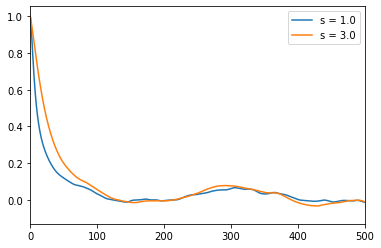

network timescales: [ 9.78 21.34]


In [15]:
timescales = []
for idx in range(K):
    timescales.append(rnn.FWHM_funct(tau_timeline , C_phi_avg[idx]))
    
    
plt.figure()

for idx in range(K):
    plt.plot(tau_timeline, C_phi_avg[idx], label = f's = {s_values[idx]}')
    
plt.xlim(0,500)
plt.legend()
plt.show()
    
print(f'network timescales: {np.round(timescales,2)}')